# **Importing Dependencies**

In [220]:
import os
from typing import Any
import nltk
import nltk.internals
import pandas as pd

In [221]:
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

# **Loading the Interviews and Pre-Processing them**


## **Splitting text into smaller chunks**

In [224]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 8000,
    separators=["\n\n","\n", "Interviewer"],
    length_function=len,
    is_separator_regex=False
)

In [225]:
collection=[]
for interview in interviews:
    doc = text_splitter.create_documents([interview])
    collection.append(doc)

In [226]:
def format_docs(collection):
    texts=[]
    for docs in collection:
        for doc in docs:
            texts.append(doc.page_content)
    return texts

texts = format_docs(collection)

# **Extracting codes from the interviews**

In [227]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

In [232]:
class Codes(BaseModel):
    Name: str
    Description: str
    Quote: str

parser = JsonOutputParser(pydantic_object=Codes)

In [231]:
open_api_key = ""
os.environ["OPENAI_API_KEY"]=open_api_key
model_name = "gpt-4o-mini"
model = ChatOpenAI(model_name = model_name, temperature = 0)

In [233]:
prompt_text = """
You are an expert in inductive thematic analysis. You will code the transcript independently, without using a pre-existing codebook. This is the initial coding stage, where insights will be drawn directly from the text. The results from this stage will determine the subsequent theme generation process.

You are provided text from transcripts of interviews with parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). The text is about the desires, wants, and meaningful outcomes of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open surgery.

In this stage, you will generate codes. Codes are the foundational units of inductive thematic analysis, capturing significant concepts and ideas from the transcripts. Each code includes a concise name, a meaningful description, and representative quotes from the transcripts.

In this task, a 'code' should be related to the desires, needs, and meaningful outcomes for parents of children with AAOCA. Codes pertain to parents. Codes describe the feeling of the parent themselves; how the parent feels towards the child or because of the child.

For example, a code could detail the idea of how a parent fears how the child will reintegrate into social society after surgery, but it could not detail a parent recounting how the child told the parent that the child fears reintegrating into social society.

Your goal is to carefully look through the text and identify all codes discussed by the parents exhaustively. Each code should be very specific and distinct. You will be rewarded $1000 if you can complete this effectively.

Identify all relevant codes in the text, provide a Name for each code in 8 to 15 words in sentence case.

Write with concise, concrete details and avoid clichés, generalizations.

Give a dense Description of the code in 80 words and direct Quotes from the participant for each code in around 120 words. These quotes can consist of multiple excerpts from the text.

Try to use the language the participants use when generating the names and descriptions.

Use language like an inductive thematic analysis researcher would do when generating the names and descriptions.

Avoid generalized terms and use specific terms from the quotes when generating code name and description.

You can use this example below as guide. This example was generated by an inductive thematic analysis researcher working from the interview transcripts of actual AAOCA patients. Note that this example is from an actual patient and not the parent so adapt accordingly. Here is the example:

--- Start Example ---
Code: Being able to physically keep up with peers
Description: Individuals frequently reported physical activity, in particular during physical education classes in school, as a point where they stood out as different (both self-perceived and called out by others) because they could not participate as fully as their peers. In addition, as individuals age, many reported self-selecting hobbies and activities that did not require significant physical activity.
Quote: "When I was in 8th grade I wanted to join the poms squad with my friend and that was a big thing. And so, I remember we were trying out and then at the school the parents had to sign a permission slip and I had to get a doctor's note and this doctor that told me, "Feel free to know your limitations", he wouldn't sign it and so I was, I mean, oh my gosh. At whatever age you are, thirteen, I lose it. I mean, I was just so upset…"
--- End Example ---

Format the response strictly as a JSON output keeping Name, Description and Quotes together in the JSON, and keep them together in Codes.
The response should start from Codes as a JSON output.
text: {text}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

LLMchain = {"text": lambda x:x} | prompt | model | parser

In [234]:
codes = LLMchain.batch(texts, {"max_concurrency": 20})

In [235]:
# collections = [parser.invoke(theme)['Themes'] for theme in themes]
collections = [code['Codes'] for code in codes]
list_of_codes = []
for codes in collections:
    for code in codes:
        list_of_codes.append(code)

list_of_codes

[{'Name': "Desire for simplicity in discussing the child's condition",
  'Description': "Parents expressed a strong preference for simplifying the terminology surrounding their child's heart condition. They often referred to it in basic terms, such as 'heart condition' or 'congenital heart defect,' to avoid confusion and to make it more relatable to others who may not understand the medical jargon. This desire for simplicity reflects their need to protect their child from unnecessary worry and to facilitate easier communication with family and friends.",
  'Quotes': ["I just say, 'Anomalous right coronary.' That's what I do.",
   "We've kept it simple, anomalous right coronary artery.",
   "Just his heart condition, that's really all we say about it."]},
 {'Name': 'Protecting the child from the emotional burden of the condition',
  'Description': "Parents frequently mentioned their efforts to shield their children from the emotional weight of having a heart condition. They often chose 

In [236]:
df_codes = pd.DataFrame(columns=['Code','Description','Quote'])
for i,code in enumerate(list_of_codes):
        df_codes.loc[i,'Code'] = code['Name']
        df_codes.loc[i,'Description'] = code['Description']
        df_codes.loc[i,'Quote'] = code['Quotes']

df_codes

,Code,Description,Quote
0,Desire for simplicity in discussing the child'...,Parents expressed a strong preference for simp...,"[I just say, 'Anomalous right coronary.' That'..."
1,Protecting the child from the emotional burden...,Parents frequently mentioned their efforts to ...,[I wouldn't even let my son know about it. I d...
2,Relief after surgery but facing ongoing uncert...,Parents conveyed a sense of relief following t...,"[At this point, we're in the relief stage, but..."
3,Seeking reassurance and second opinions from m...,Parents often sought reassurance through multi...,[I ended up going to so many different doctors...
4,Desire for reassurance about child's heart con...,Parents express a strong need for reassurance ...,"[We are hoping that everything will be fine, b..."
...,...,...,...
385,Valuing supportive relationships with healthca...,Parents highlight the importance of having sup...,"[My doctor has made herself available to us., ..."
386,The importance of advocacy and informed decisi...,Parents express a strong desire to advocate fo...,[I think it would just be to advocate for your...
387,Desire for supportive and communicative health...,Parents expressed a strong need for healthcare...,[Our doctor encouraged us to get a second opin...
388,Wishing for earlier awareness of the child's c...,Parents reflected on their desire for earlier ...,[I wish I would've known that the official dia...


In [96]:
df_codes.to_csv(f"C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_2_mini/df_codes_parents.csv", index=False)

In [19]:
# df_codes = pd.read_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_1/df_codes_parents.csv")
# df_codes

## **Removing Duplicate Codes**

In [237]:
parser = StrOutputParser()

In [238]:
summarization_prompt_text = """Combine the following descriptions into a single, concise description.
Write with concise, concrete details and avoid clichés, generalizations.

Descriptions:
{descriptions}
"""

summarization_prompt = ChatPromptTemplate.from_template(summarization_prompt_text)

In [239]:
grouped_codes = df_codes.groupby("Code", sort=False).agg({
    "Description": list,
    "Quote": list}).reset_index()

In [240]:
unique_codes_output = []
for _, row in grouped_codes.iterrows():
    code_name = row["Code"]
    descriptions = "\n".join(row["Description"])
    quotes = row["Quote"]
    if len(row["Description"]) > 1:
        response = summarization_prompt | model | parser
        summary = response.invoke({"descriptions": descriptions})
    else:
        summary = descriptions

    unique_code = {"Unified_code_name":code_name, "Combined_description":summary, "Quotes":quotes}
    
    unique_codes_output.append(unique_code)

In [241]:
df_unique_codes = pd.DataFrame(columns=['Unique_Code','Description', 'Quotes'])
for i, unique_code in enumerate(unique_codes_output):
        df_unique_codes.loc[i,'Unique_Code'] = unique_code['Unified_code_name']
        df_unique_codes.loc[i,'Description'] = unique_code['Combined_description']
        df_unique_codes.loc[i,'Quotes'] = unique_code['Quotes']

df_unique_codes

,Unique_Code,Description,Quotes
0,Desire for simplicity in discussing the child'...,Parents expressed a strong preference for simp...,"[[I just say, 'Anomalous right coronary.' That..."
1,Protecting the child from the emotional burden...,Parents frequently mentioned their efforts to ...,[[I wouldn't even let my son know about it. I ...
2,Relief after surgery but facing ongoing uncert...,Parents conveyed a sense of relief following t...,"[[At this point, we're in the relief stage, bu..."
3,Seeking reassurance and second opinions from m...,Parents often sought reassurance through multi...,[[I ended up going to so many different doctor...
4,Desire for reassurance about child's heart con...,Parents express a strong need for reassurance ...,"[[We are hoping that everything will be fine, ..."
...,...,...,...
369,Valuing supportive relationships with healthca...,Parents highlight the importance of having sup...,"[[My doctor has made herself available to us.,..."
370,The importance of advocacy and informed decisi...,Parents express a strong desire to advocate fo...,[[I think it would just be to advocate for you...
371,Desire for supportive and communicative health...,Parents expressed a strong need for healthcare...,[[Our doctor encouraged us to get a second opi...
372,Wishing for earlier awareness of the child's c...,Parents reflected on their desire for earlier ...,[[I wish I would've known that the official di...


In [25]:
# df_unique_codes = pd.read_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_1/df_unique_codes_parents.csv")
# df_unique_codes

In [ ]:
# df_unique_codes.to_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_2_mini/df_unique_codes_parents.csv", index=False)

## **Finding major themes from the unique codes**

### **Initial generation of themes from chunks of topics**

In [306]:
class Themes(BaseModel):
    Group: str
    Description: str
    Original_Topics: list[str]
    
parser = JsonOutputParser(pydantic_object=list[Themes])

In [307]:
# Prompt for generating initial themes from each chunk
chunk_prompt_template = """
You are working on Inductive Thematic Analysis. This is the theme identification stage. You are provided results from the initial code stage: text that has initial codes with their descriptions and relevant Quotes.

These initial codes are generated from interview transcripts of parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). It is about the desires, wants and outcomes of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open heart surgery.

Your task at this stage is to group the initial codes into distinct themes, descriptions, and quotes.
Make sure you use all the codes in the text to generate the themes. Each code must be under one theme and each code can be under more than one theme if relevant. List all the relevant codes under each major theme.

A 'theme' is the wants, needs, meaningful outcomes, and lived experiences of parents of individuals diagnosed with AAOCA. Achieving these would be ensure success in caring for the condition from the parents perspective.

Themes pertain to parents. Themes describe the feeling of the parent themselves; how the parent feels towards the child or because of the child.

For example, a theme could detail the idea of a parent's fears about how the child will reintegrate into society after surgery. However, the theme should not detail a parent recounting how the child told the parent that the child fears reintegrating into society. 

Each theme should be specific and distinct.

Each theme should be distinct and cover a set of codes that are related to each other. 

Provide a descriptive and specific name of 8 to 15 words for each theme based on the code's names, quotes and descriptions. The name of the themes are the desires, needs, and most meaningful outcomes for parents of children with AAOCA.

Write with concise, concrete details and avoid clichés, generalizations. 

The theme name should be an action with the subject being parents. Omit the default subject (parents) and the disease from the name.

Write the theme name in sentence case.

Provide a detailed description of 60 to 80 words for each theme.

Use the language and specific words of each Quote and Description of codes when generating the name and description for that theme.

Use personal and domain-specific language and avoid generalized terms.

Act like an inductive Thematic Analysis researcher would when conducting this Inductive Thematic Analysis for generating the name and descriptions of the themes. You will be rewarded $1000 if you can complete this effectively. 

Also provide all the codes that fall under each theme.

You can use this example below as guide. This example was generated by an inductive thematic analysis researcher working from the interview transcripts of actual AAOCA patients. Note that this example is from an actual patient and not the parent so adapt accordingly. Here is the example:

--- Start Example ---
Theme: Being able to continue to do the things I want/love
Description: The disruption an AAOCA diagnosis can have on one’s daily life was a prominent topic brought up. Participants spoke of how the diagnosis and/or the exercise restrictions altered both their current activities, including participating in athletics, as well as altering future plans including prohibiting individuals from joining the military, or not being able to get athletic scholarships to college requiring them to change college plans. 
Codes: Anger at AAOCA,
Impact of activity restrictions,
Disregarding physician placed activity restrictions,
Choice between intervention and limitation,
Impact on school,
Diagnosis impact on future,
How the condition shaped future ambitions/career choices,
Navigating friendships after the diagnosis,
Not wanting to be seen as different,
Changing your lifestyle and routine
--- End Example ---

Format the response strictly as a JSON output, keeping Name, Description, and all Codes under 'Themes' together in the JSON. The response should start from Themes as a JSON output.

text = {text}
"""
chunk_prompt = ChatPromptTemplate.from_template(chunk_prompt_template)

In [308]:
# Function to format data for the prompt
def format_dataframe(df):
    text = ""
    for _, row in df.iterrows():
        text += f"Topics: {row['Unique_Code']}, Description: {row['Description']}, Quotes: {row['Quotes']}\n"
    return text

# Step 1: Split data into chunks
chunk_size = 70  # Adjust based on input length limits and complexity
chunks = [df_unique_codes[i:i + chunk_size] for i in range(0, len(df_unique_codes), chunk_size)]

In [309]:
# Step 2: Process each chunk independently to gather preliminary themes
all_initial_themes = []
for chunk in chunks:
    text = format_dataframe(chunk)
    # Process each chunk to generate preliminary themes
    response = chunk_prompt | model | parser
    chunk_themes = response.invoke({"text": text})
    print(chunk_themes)

    if isinstance(chunk_themes, dict) and "Themes" in chunk_themes:
        chunk_themes = chunk_themes["Themes"]
        all_initial_themes.append(chunk_themes)
    elif isinstance(chunk_themes, dict) and "themes" in chunk_themes:
        chunk_themes = chunk_themes["themes"]
        all_initial_themes.append(chunk_themes)
    else:
        print("Unexpected response format:", chunk_themes)
        all_initial_themes.append(chunk_themes)

{'Themes': [{'Name': "Desiring simplicity in discussing my child's condition", 'Description': "Parents expressed a strong preference for simplifying the terminology surrounding their child's heart condition. They often referred to it in basic terms, such as 'heart condition' or 'congenital heart defect,' to avoid confusion and to make it more relatable to others who may not understand the medical jargon. This desire for simplicity reflects their need to protect their child from unnecessary worry and to facilitate easier communication with family and friends.", 'Codes': ["Desire for simplicity in discussing the child's condition"]}, {'Name': 'Protecting my child from the emotional burden of the condition', 'Description': "Parents frequently mentioned their efforts to shield their children from the emotional weight of having a heart condition. They often chose not to discuss the specifics of the diagnosis in front of their children, aiming to maintain a sense of normalcy and prevent feel

In [310]:
# groups = [group for sublist in all_initial_themes for group in parser.invoke(sublist)['Groups']]
groups = [group for sublist in all_initial_themes for group in sublist]

for group in groups:
    print(group)

{'Name': "Desiring simplicity in discussing my child's condition", 'Description': "Parents expressed a strong preference for simplifying the terminology surrounding their child's heart condition. They often referred to it in basic terms, such as 'heart condition' or 'congenital heart defect,' to avoid confusion and to make it more relatable to others who may not understand the medical jargon. This desire for simplicity reflects their need to protect their child from unnecessary worry and to facilitate easier communication with family and friends.", 'Codes': ["Desire for simplicity in discussing the child's condition"]}
{'Name': 'Protecting my child from the emotional burden of the condition', 'Description': "Parents frequently mentioned their efforts to shield their children from the emotional weight of having a heart condition. They often chose not to discuss the specifics of the diagnosis in front of their children, aiming to maintain a sense of normalcy and prevent feelings of being

### **Consolidation of initial themes into major themes**

In [330]:
# Step 3: Consolidate all initial themes
consolidation_prompt_template = """
You are conducting Inductive Thematic Analysis. You are at the final theme generation stage. You are provided preliminary themes, with their descriptions and relevant codes under them.

These preliminary themes and codes are generated from interview transcripts of parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). It is about the desires and wants of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open heart surgery.

A 'theme' is the wants, needs, meaningful outcomes, and lived experiences of parents of individuals diagnosed with AAOCA. Achieving these would be ensure success in caring for the condition from the parents perspective.

Themes pertain to parents. Themes describe the feeling of the parent themselves; how the parent feels towards the child or how they feel because of the child.

For example, a theme could detail the idea of a parent's fears about how the child will reintegrate into society after surgery. However, the theme should not detail a parent recounting how the child told the parent that the child fears reintegrating into society. 

Review and consolidate the following preliminary themes into exactly twelve (12) overarching major themes. List all the relevant codes under each major theme.

Each major theme should be distinct from the others.

The major themes will be used to write the final report.

Use personal and domain-specific language and avoid generalized terms to generate names and descriptions of the final themes.

Write with concise, concrete details and avoid clichés and generalizations.

Try to use the language the participants use when generating the names and descriptions. Directly use the language from the quotes and descriptions.

The final theme name should be an action with the subject being parents. Although omit the default subject (parents) and the disease from the name.

Write the final theme name in sentence case.

The name of the theme should consist of 8 to 15 words.

Each final theme should have a description of 60 to 80 words and list all relevant codes.

Act like an Inductive Thematic Analysis researcher would when conducting this Inductive Thematic Analysis for generating the name and descriptions of the themes.

The name of the themes are the desires, needs, and most meaningful outcomes for parents of children with AAOCA. Achieving these would be successful in caring for the condition from the parents perspective. You will be rewarded $1000 if you can complete this effectively.

You can use this example below as guide. This example was generated by an inductive thematic analysis researcher working from the interview transcripts of actual AAOCA patients. Note that this example is from an actual patient and not the parent so adapt accordingly. Here is the example:

--- Start Example ---
Theme: Being able to continue to do the things I want/love
Description: The disruption an AAOCA diagnosis can have on one’s daily life was a prominent topic brought up. Participants spoke of how the diagnosis and/or the exercise restrictions altered both their current activities, including participating in athletics, as well as altering future plans including prohibiting individuals from joining the military, or not being able to get athletic scholarships to college requiring them to change college plans. 
Topics: Anger at AAOCA,
Impact of activity restrictions,
Disregarding physician placed activity restrictions,
Choice between intervention and limitation,
Impact on school,
Diagnosis impact on future,
How the condition shaped future ambitions/career choices,
Navigating friendships after the diagnosis,
Not wanting to be seen as different,
Changing your lifestyle and routine
--- End Example ---

Consolidate the following preliminary themes into 12 overarching major themes as per the instructions and example provided.
Preliminary Themes:
{themes}

Format the response strictly as a JSON output, keeping Name, Description, and all Codes under 'Themes' together in the JSON. The response should start from Themes as a JSON output.
"""
consolidation_prompt = ChatPromptTemplate.from_template(consolidation_prompt_template)

In [331]:
# Prepare input for the consolidation step
consolidation_text = "\n".join([f"Theme: {theme['Name']}, Description: {theme['Description']}, Codes: {', '.join(theme['Codes'])}" for 
                                sublist in all_initial_themes for theme in sublist])

In [332]:
# Create final prompt for consolidation
final_response = consolidation_prompt | model | parser
final_themes = final_response.invoke({"themes": consolidation_text}, max_concurrency=20)

In [334]:
final_themes

{'Themes': [{'Name': "Desiring simplicity in discussing my child's condition",
   'Description': "Parents express a strong preference for simplifying the terminology surrounding their child's heart condition. They often refer to it in basic terms, such as 'heart condition' or 'congenital heart defect,' to avoid confusion and to make it more relatable to others. This desire for simplicity reflects their need to protect their child from unnecessary worry and to facilitate easier communication with family and friends.",
   'Codes': ["Desire for simplicity in discussing the child's condition"]},
  {'Name': 'Protecting my child from the emotional burden of the condition',
   'Description': "Parents frequently mention their efforts to shield their children from the emotional weight of having a heart condition. They often choose not to discuss the specifics of the diagnosis in front of their children, aiming to maintain a sense of normalcy and prevent feelings of being different or unwell. Th

In [335]:
collections = final_themes['Themes']
# collections = final_themes
df_themes = pd.DataFrame(columns=['Theme','Description','Original_Codes'])
for i,theme in enumerate(collections):
    df_themes.loc[i,'Theme'] = theme['Name']
    df_themes.loc[i,'Description'] = theme['Description']
    df_themes.loc[i,'Original_Codes'] = theme['Codes']

df_themes

,Theme,Description,Original_Codes
0,Desiring simplicity in discussing my child's c...,Parents express a strong preference for simpli...,[Desire for simplicity in discussing the child...
1,Protecting my child from the emotional burden ...,Parents frequently mention their efforts to sh...,[Protecting the child from the emotional burde...
2,Navigating relief after surgery while facing o...,Parents convey a sense of relief following the...,[Relief after surgery but facing ongoing uncer...
3,Seeking reassurance and second opinions from m...,Parents often seek reassurance through multipl...,[Seeking reassurance and second opinions from ...
4,Living with constant worry and uncertainty abo...,Parents articulate a pervasive sense of worry ...,[Living with constant worry and uncertainty]
5,Desiring clear communication and understanding...,Parents express a strong need for clear and co...,[Desire for clear communication and informatio...
6,Coping with the emotional aftermath of diagnos...,The emotional response to the diagnosis of the...,[Coping with the emotional aftermath of diagno...
7,Struggling with feelings of guilt and responsi...,Parents grapple with guilt and a heavy sense o...,[Struggle with feelings of guilt and responsib...
8,Finding community support through shared exper...,Parents highlight the importance of connecting...,[Finding community support through shared expe...
9,Balancing hope and fear during my child's reco...,Parents articulate the struggle of maintaining...,[Balancing hope and fear during recovery]


In [336]:
length = 0
for codes in df_themes['Original_Codes']:
    length += len(codes)

length

14

In [ ]:
# df_themes.to_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_2_mini/df_themes_parents.csv")

In [ ]:
# df_themes = pd.read_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_2_mini/df_themes_parents.csv")

## **Comparison with annotated themes developed by humans**

In [337]:
with open("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/AAOCA_Parents_outcomes_themes.txt",
          encoding='utf8') as fp:
    human_themes = fp.read()

In [338]:
with open("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/AAOCA_Parents_outcomes.txt",
          encoding='utf8') as fp:
    human_themes_description = fp.read()

In [339]:
human_themes_split = human_themes.split('\n\n')
descriptions_split = human_themes_description.split("\n\n")

In [340]:
df_human_themes = pd.DataFrame(columns=['Theme','Description', 'Codes'])
for i,theme in enumerate(human_themes_split):
    theme_split = theme.split(':')
    df_human_themes.loc[i,'Codes'] = theme_split[1].split('\n')[1:]

In [341]:
indexes = [11,6,10,1,4,5,8,2,7,0,9,3]

In [342]:
for i,(ind,description) in enumerate(zip(indexes,descriptions_split)):
    description_split = description.split(":\n")
    df_human_themes.loc[ind,'Theme'] = description_split[0]
    df_human_themes.loc[ind, 'Description']= description_split[1]

In [343]:
df_human_themes

,Theme,Description,Codes
0,Clarity of potential risks and outcomes,While acknowledging the current challenges of ...,"[Fear of cardiac events, Uncertainty of future..."
1,Freedom from hypervigilance related to the con...,A dominating sense of hypervigilance was descr...,"[Fear of cardiac events, Parents always on, Un..."
2,The diagnosis given in a compassionate and emp...,While the diagnosis experience was minimally d...,"[Diagnosis as traumatic and frightening, Diagn..."
3,A sense of control over the future,Receiving the diagnosis of AAOCA for their chi...,"[Lack of control over outcomes for child, Unce..."
4,Being heard and taken seriously by clinicians,"As with individuals with AAOCA, parents expres...",[Frequent challenges within the diagnostic jou...
5,Individualized support for management decision...,Similar to individuals with a diagnosis of AAO...,"[Decision between intervention and limitation,..."
6,Receiving support from others,"As in individuals with a diagnosis of AAOCA, p...",[Importance of support from family and friends...
7,Being appropriately informed,Parents also endorsed the importance of feelin...,"[Searching for answers on own, Trying to under..."
8,Partnership with the care team,Being a partner with the care team was also im...,[Importance of clinician relationships and int...
9,Feeling that my child is safe,Their child’s safety was of great importance t...,"[Planning for adverse events, Parents always o..."


In [ ]:
# df_human_themes.to_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_2_mini/df_human_themes.csv", index=False)

In [ ]:
# df_human_themes = pd.read_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/df_human_themes.csv")
# df_human_themes

In [344]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [345]:
model = SentenceTransformer('all-mpnet-base-v2')
human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)

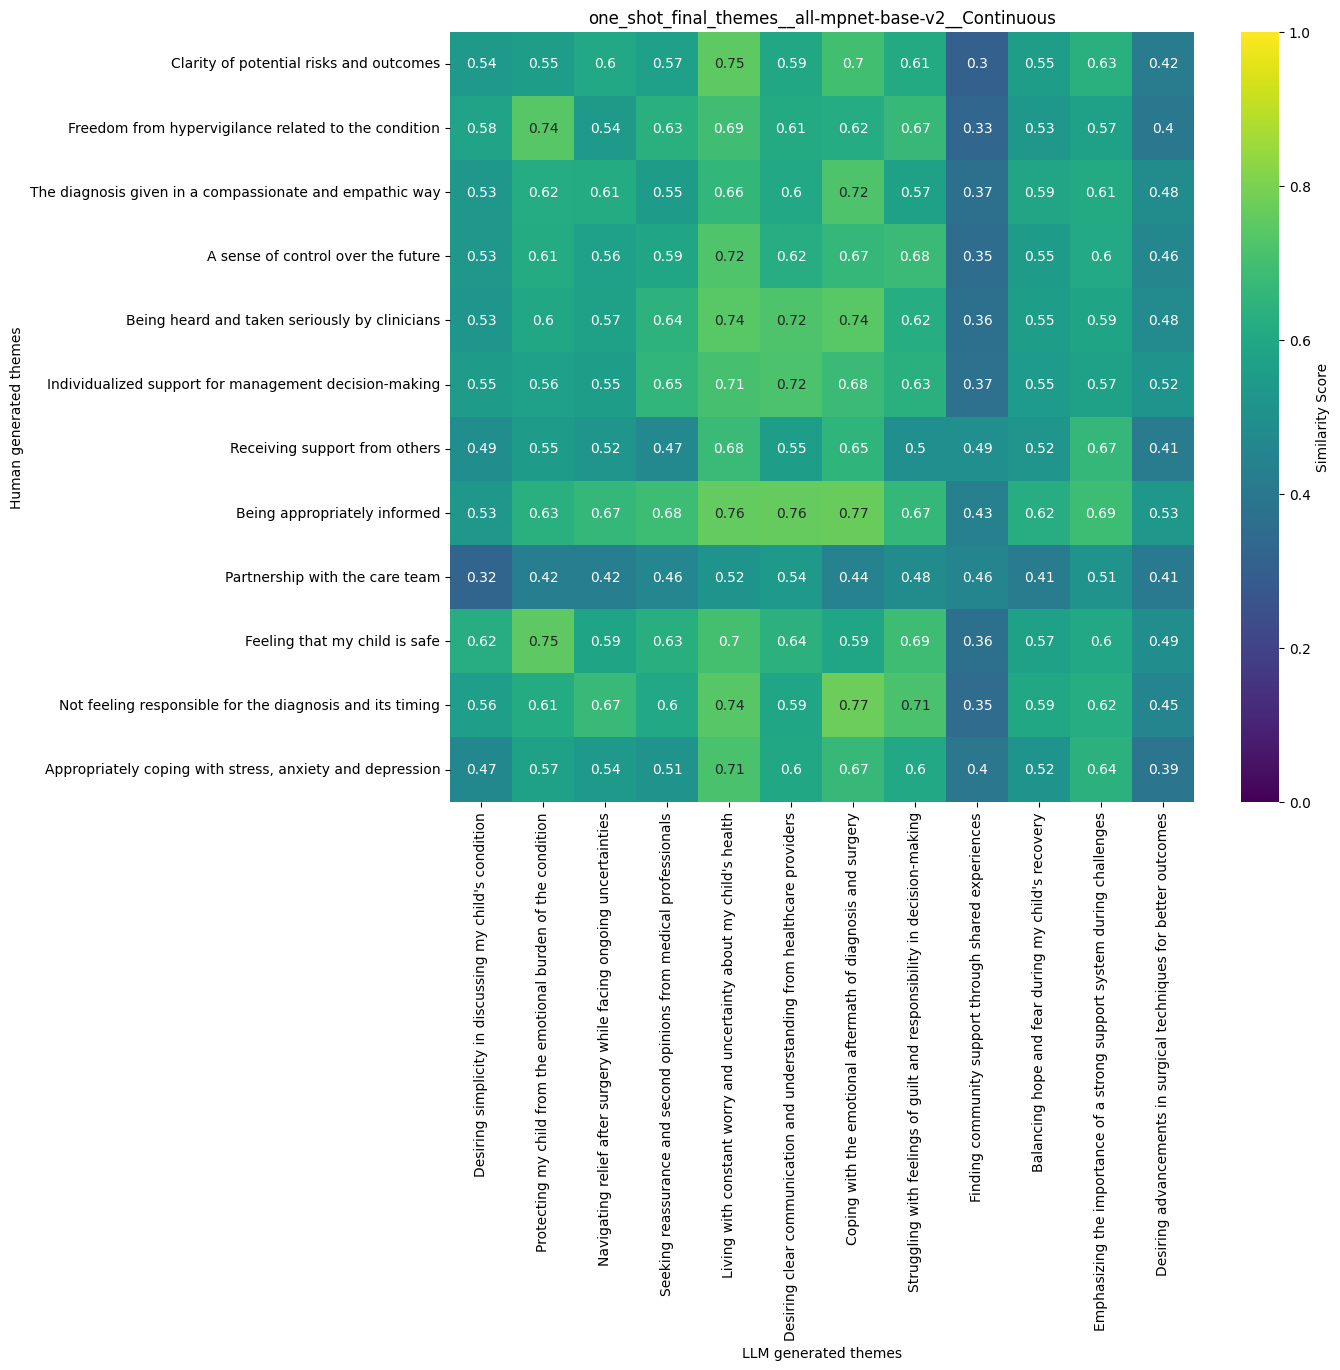

In [346]:
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('one_shot_final_themes__all-mpnet-base-v2__Continuous')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

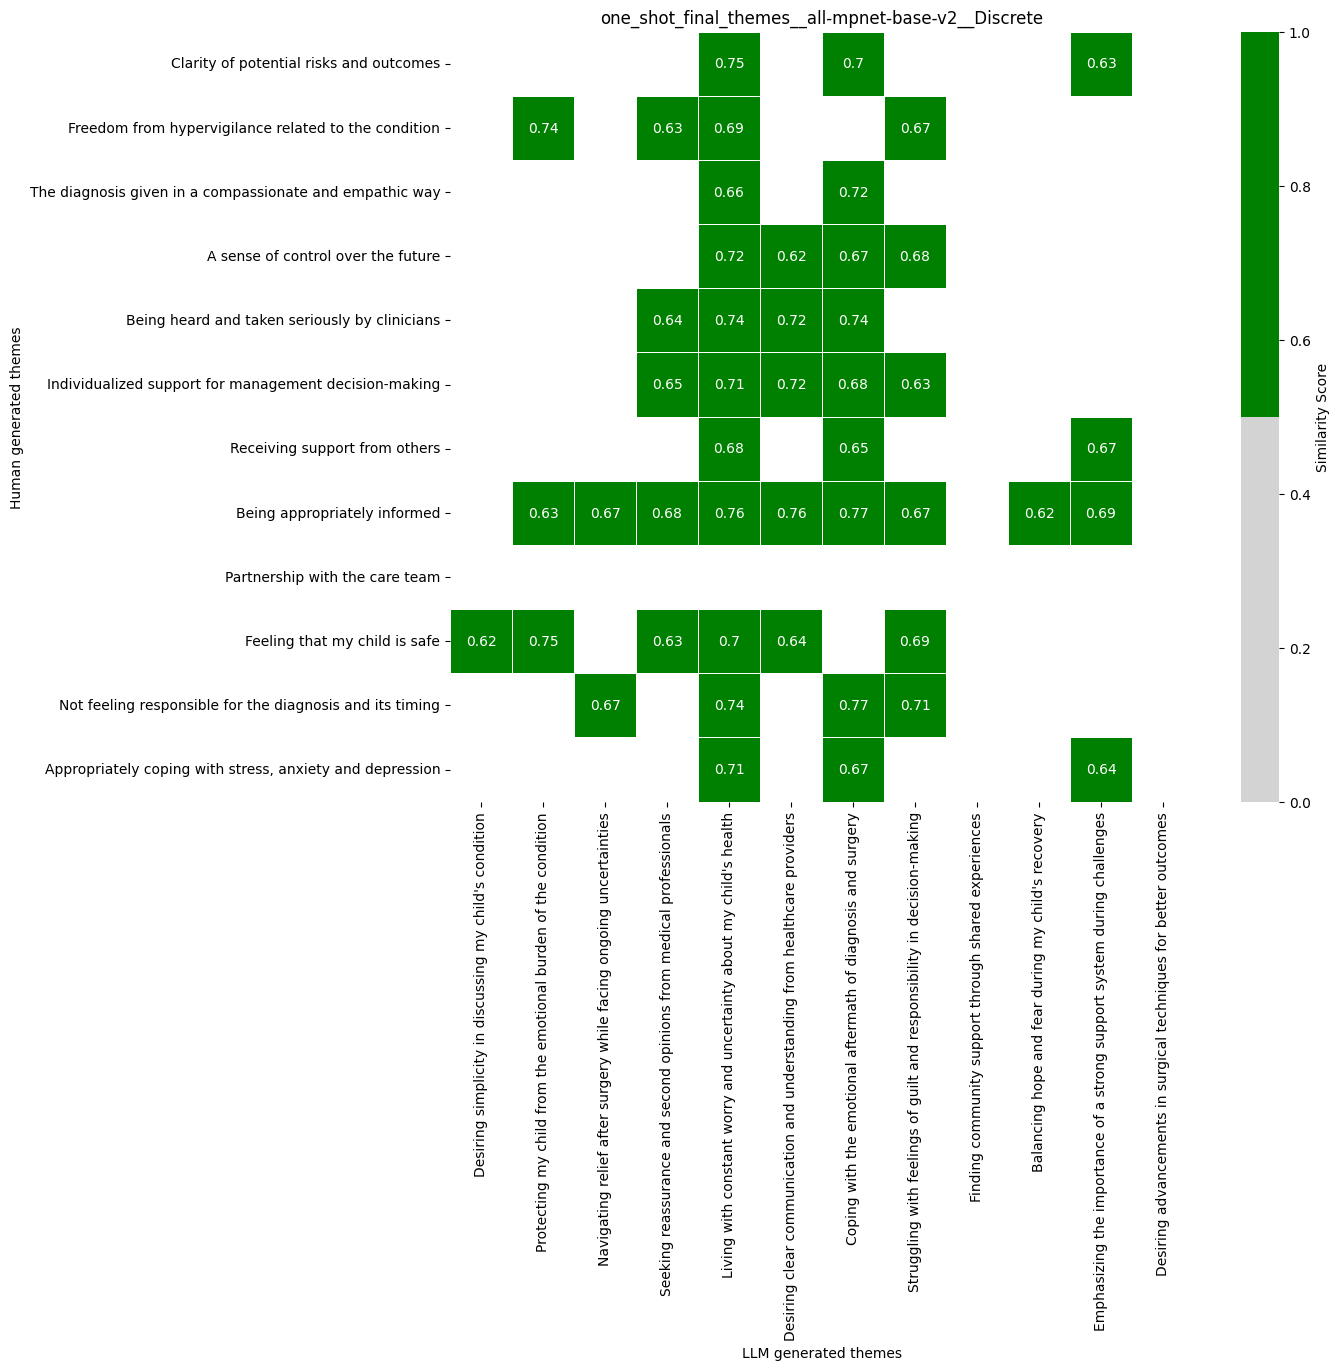

In [347]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= 0.62),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('one_shot_final_themes__all-mpnet-base-v2__Discrete')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [348]:
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > 0.62)
percent_high = (high_similarity_count*100/total_cells)
percent_high

32.638888888888886

In [349]:
model = SentenceTransformer('all-MiniLM-L6-v2')
human_desc_embeddings = model.encode(df_human_themes['Description'].tolist())
llm_desc_embeddings = model.encode(df_themes['Description'].tolist())

cosine_sim_matrix = cosine_similarity(human_desc_embeddings,llm_desc_embeddings)

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)

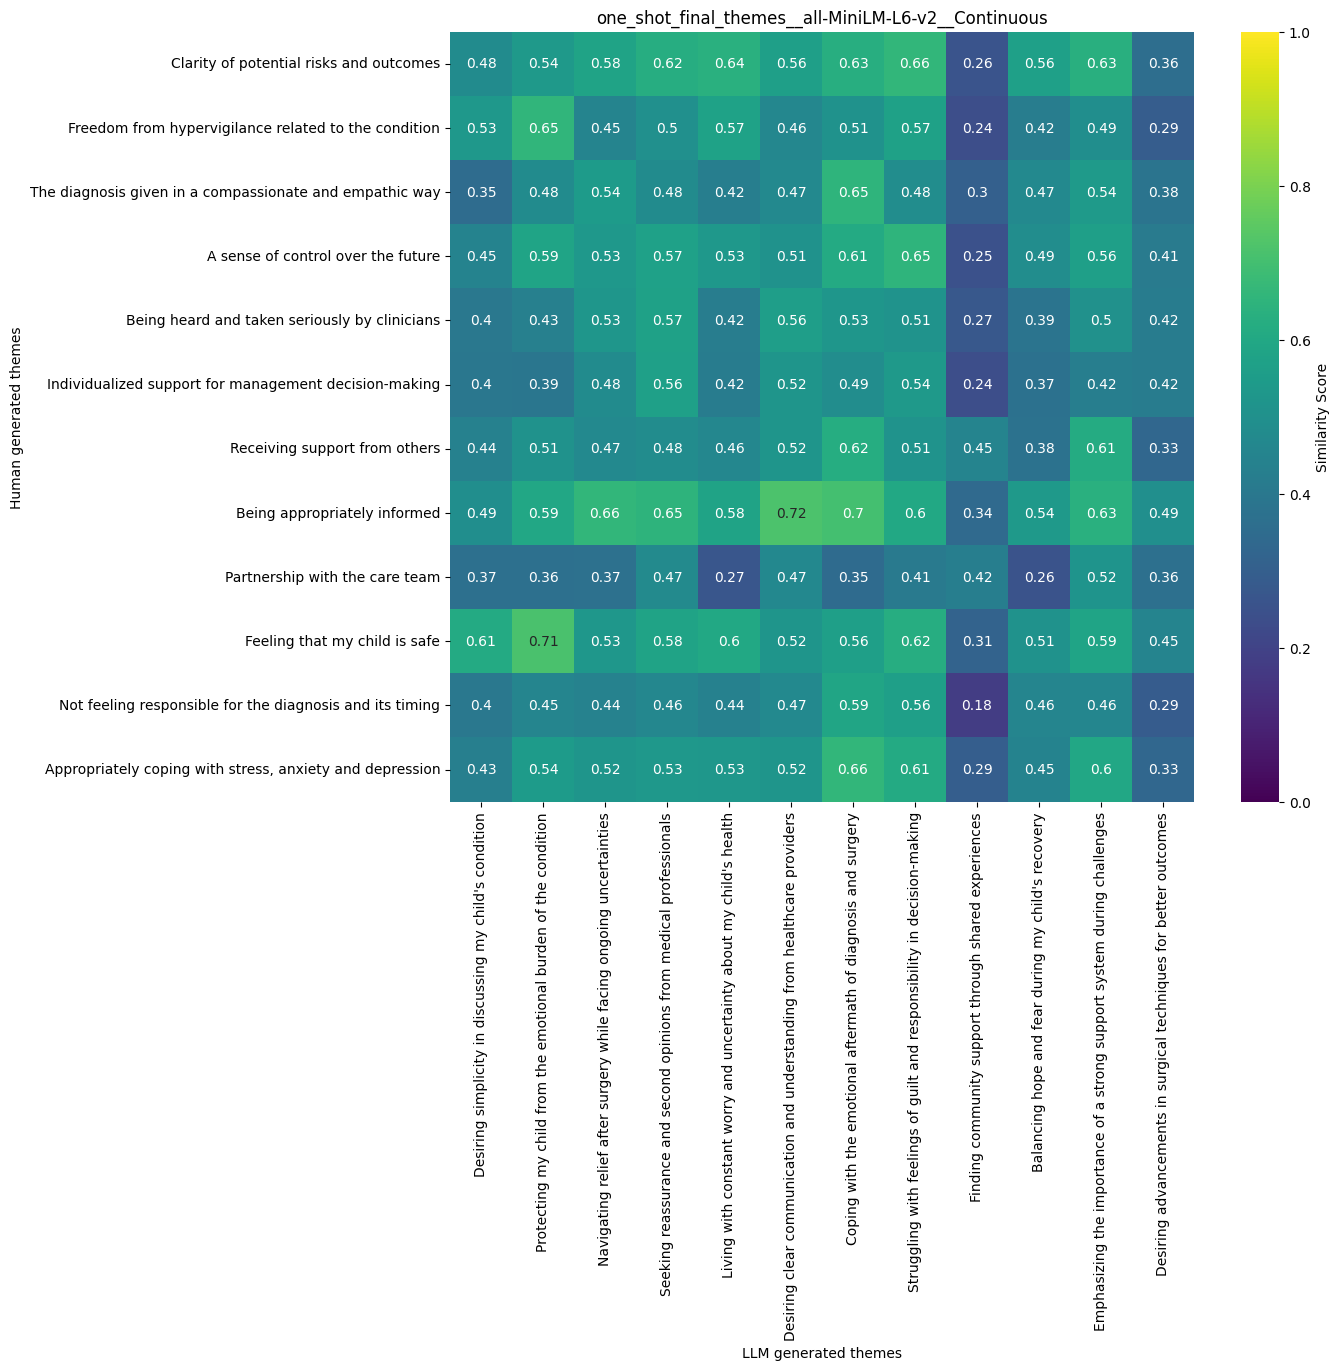

In [350]:
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('one_shot_final_themes__all-MiniLM-L6-v2__Continuous')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

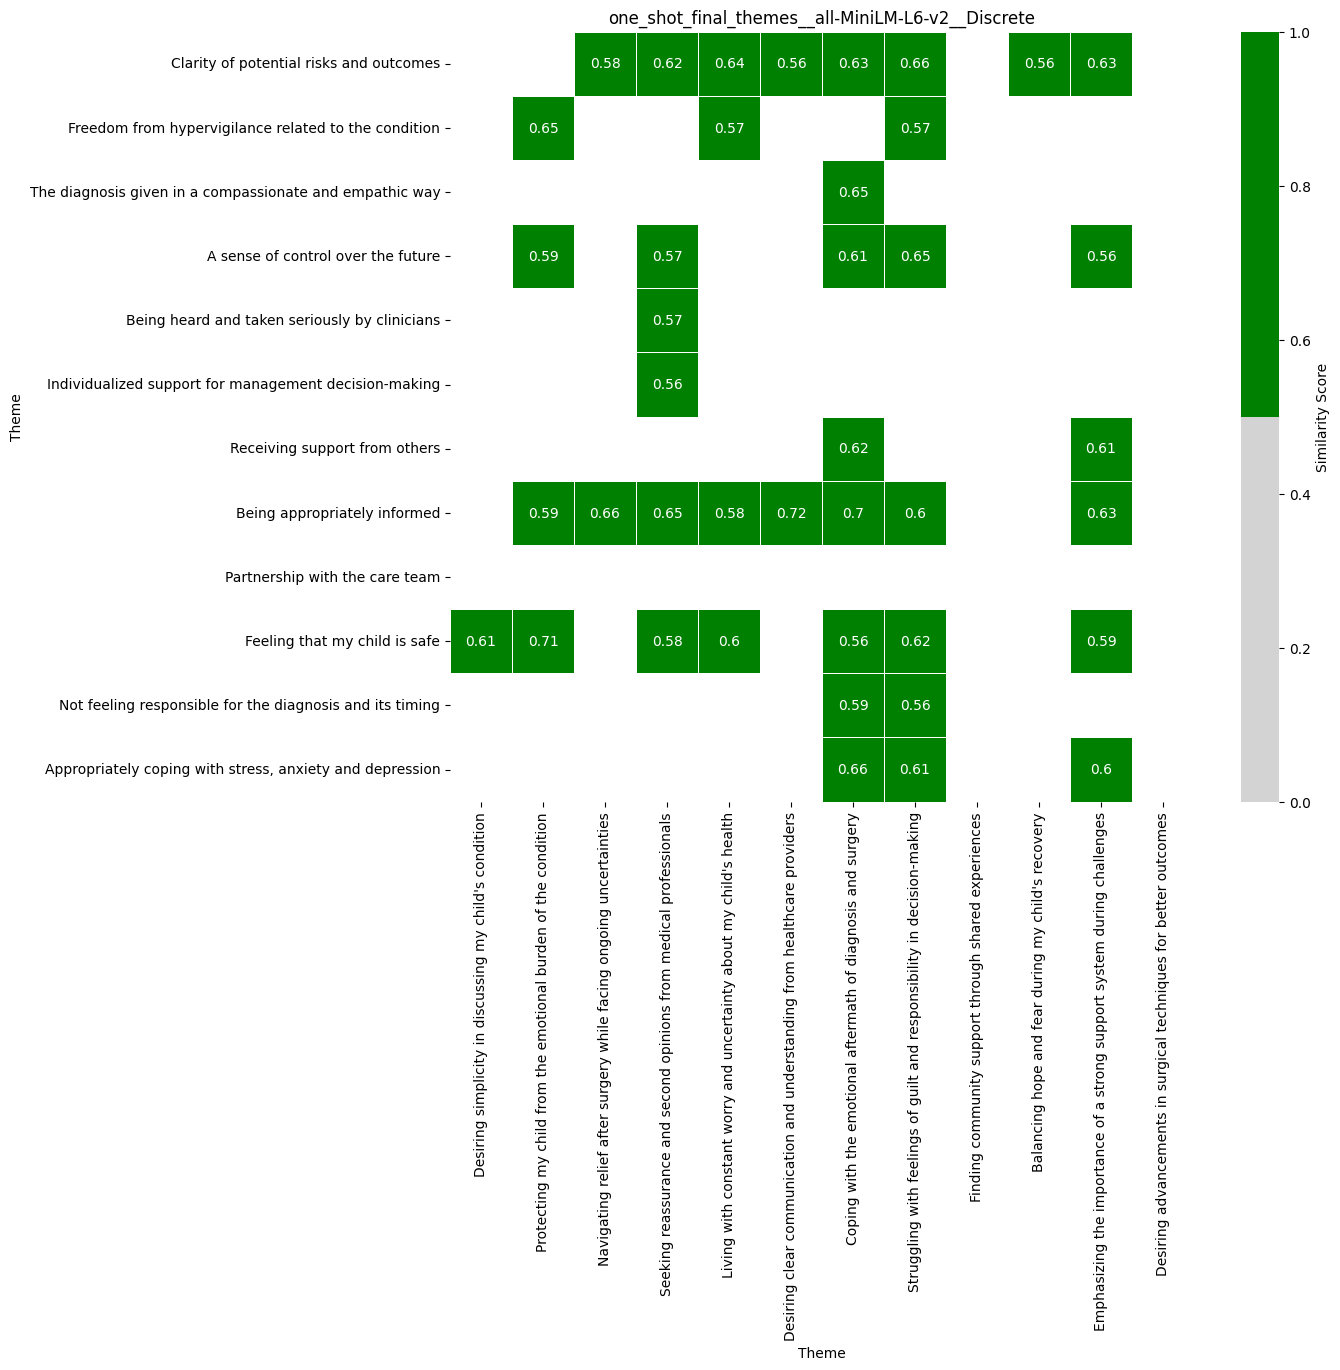

In [351]:
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= 0.56),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('one_shot_final_themes__all-MiniLM-L6-v2__Discrete')
plt.show()

In [352]:
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > 0.56)
percent_high = (high_similarity_count*100/total_cells)
percent_high

28.47222222222222

### **Sentence-t5-xxl Evaluation**

In [353]:
model = SentenceTransformer('sentence-transformers/sentence-t5-xxl')
human_desc_embeddings = model.encode(df_human_themes['Description'].tolist())
llm_desc_embeddings = model.encode(df_themes['Description'].tolist())

cosine_sim_matrix = cosine_similarity(human_desc_embeddings,llm_desc_embeddings)

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)

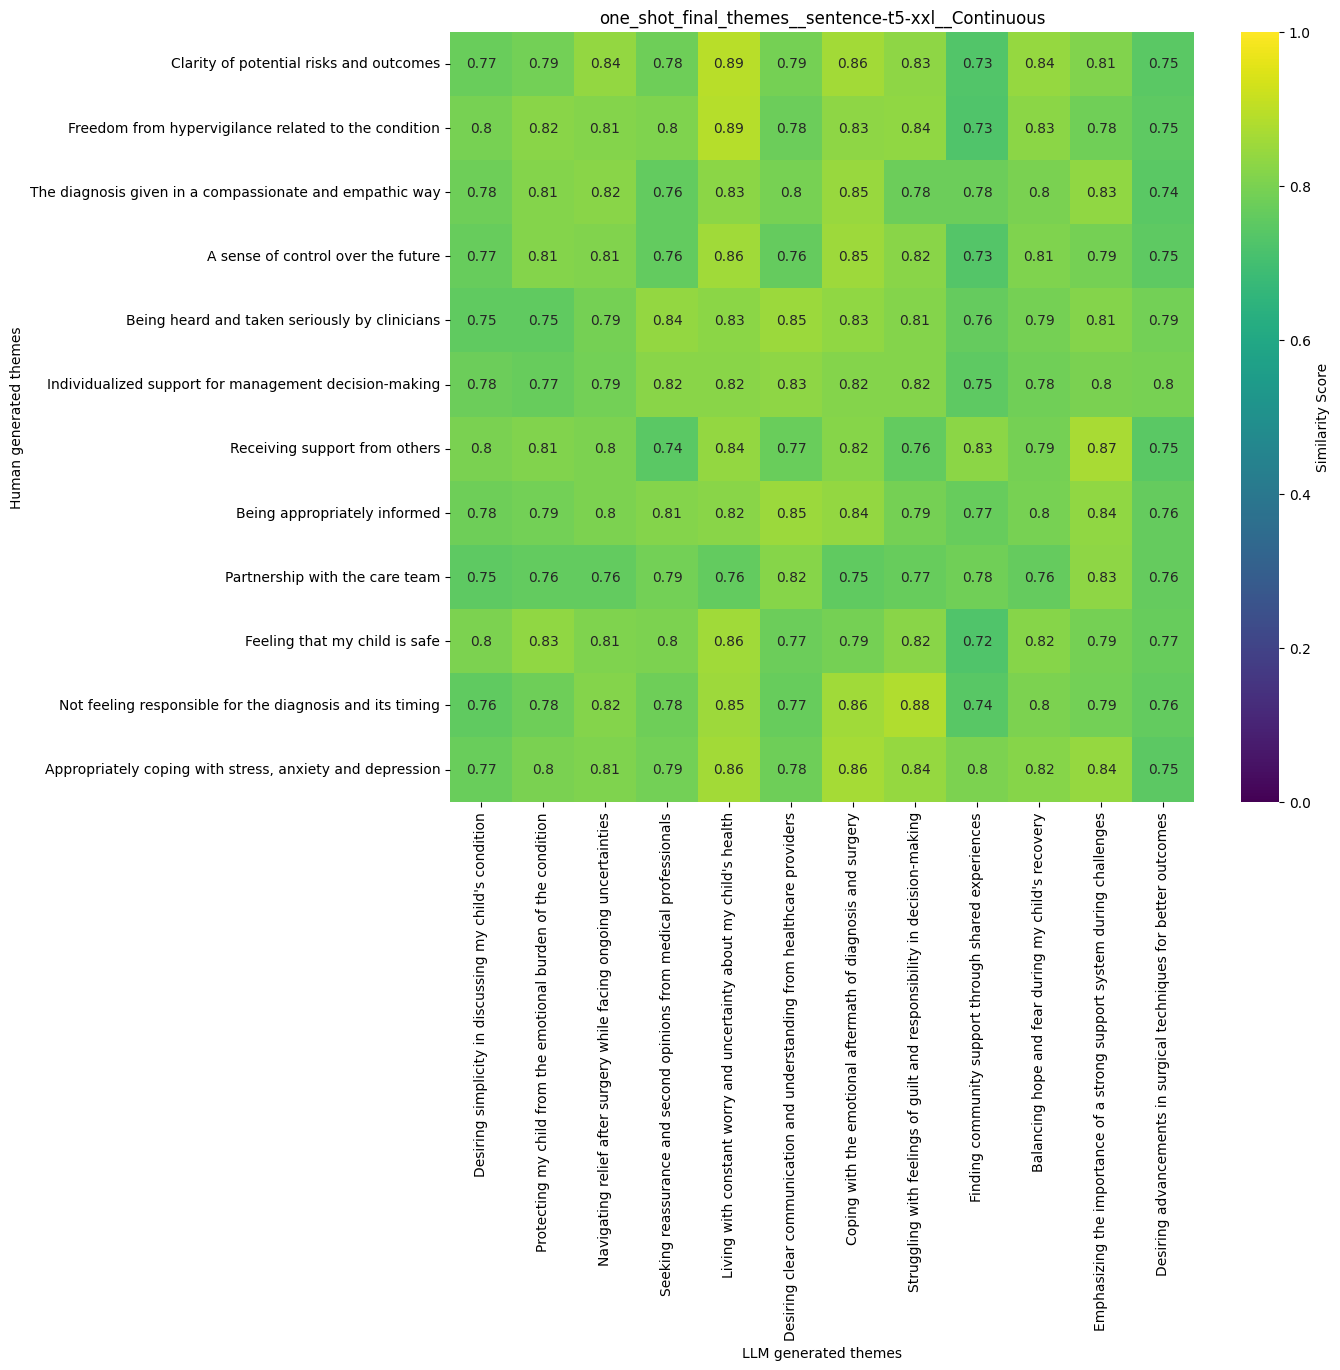

In [354]:
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('one_shot_final_themes__sentence-t5-xxl__Continuous')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

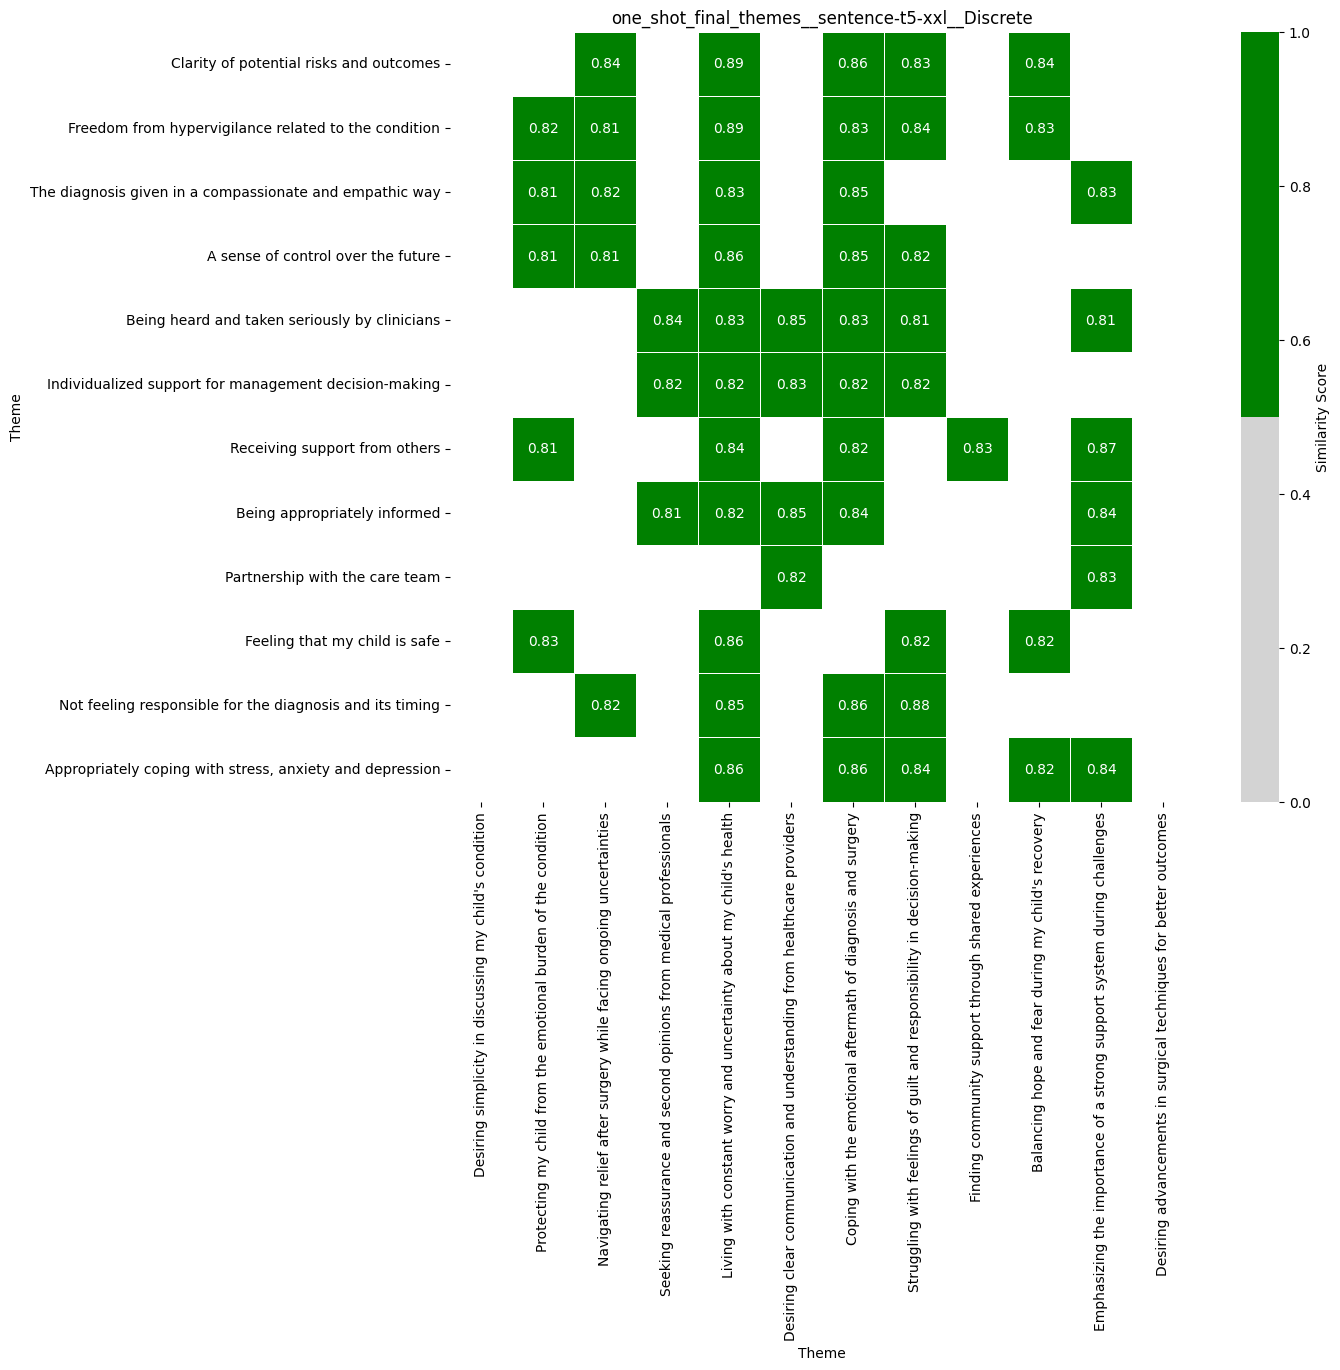

In [355]:
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= 0.81),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('one_shot_final_themes__sentence-t5-xxl__Discrete')
plt.show()

In [356]:
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > 0.81)
percent_high = (high_similarity_count*100/total_cells)
percent_high

39.583333333333336

## **LLM Based Evaluation**

In [357]:
def format_rows(llm_row, human_row):
    text = ""
    text += f"Theme 1 Name: {llm_row['Theme']}, Theme 1 Description: {llm_row['Description']}, Theme 2 Name: {human_row['Theme']}, Theme 2 Description: {human_row['Description']} "
    return text

In [358]:
model = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)
parser = StrOutputParser()
prompt_template = """
You are a qualitative research expert conducting inductive thematic analysis.  
Your task is to assess the similarity between two themes based on their names and descriptions.  

The similarity measures how much the two themes convey the same meaning, considering both overlapping ideas, concepts and the specificity of their names and descriptions.
If one of the themes is significantly more general than the other, the similarity score should be lower.
Rate the similarity on a scale from 0 to 1:  
- A score of 1 indicates the themes are identical.  
- A socre of 0 indicates they are entirely different.

Provide the similarity score as a single number rounded to three decimal places. Output **only the number**.  
Text: {text}  

Similarity Score:
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
LLMchain = prompt | model | parser
similarity_matrix_llm = pd.DataFrame(index=df_human_themes['Theme'], columns=df_themes['Theme'])
for i, llm_row in df_human_themes.iterrows():
    for j, human_row in df_themes.iterrows():
        text = format_rows(llm_row, human_row)
        response = LLMchain.invoke({"text": text})
        similarity_score = float(response)
        similarity_matrix_llm.at[llm_row['Theme'], human_row['Theme']] = similarity_score

In [359]:
similarity_llm_df=similarity_matrix_llm.iloc[:,:].astype(float)

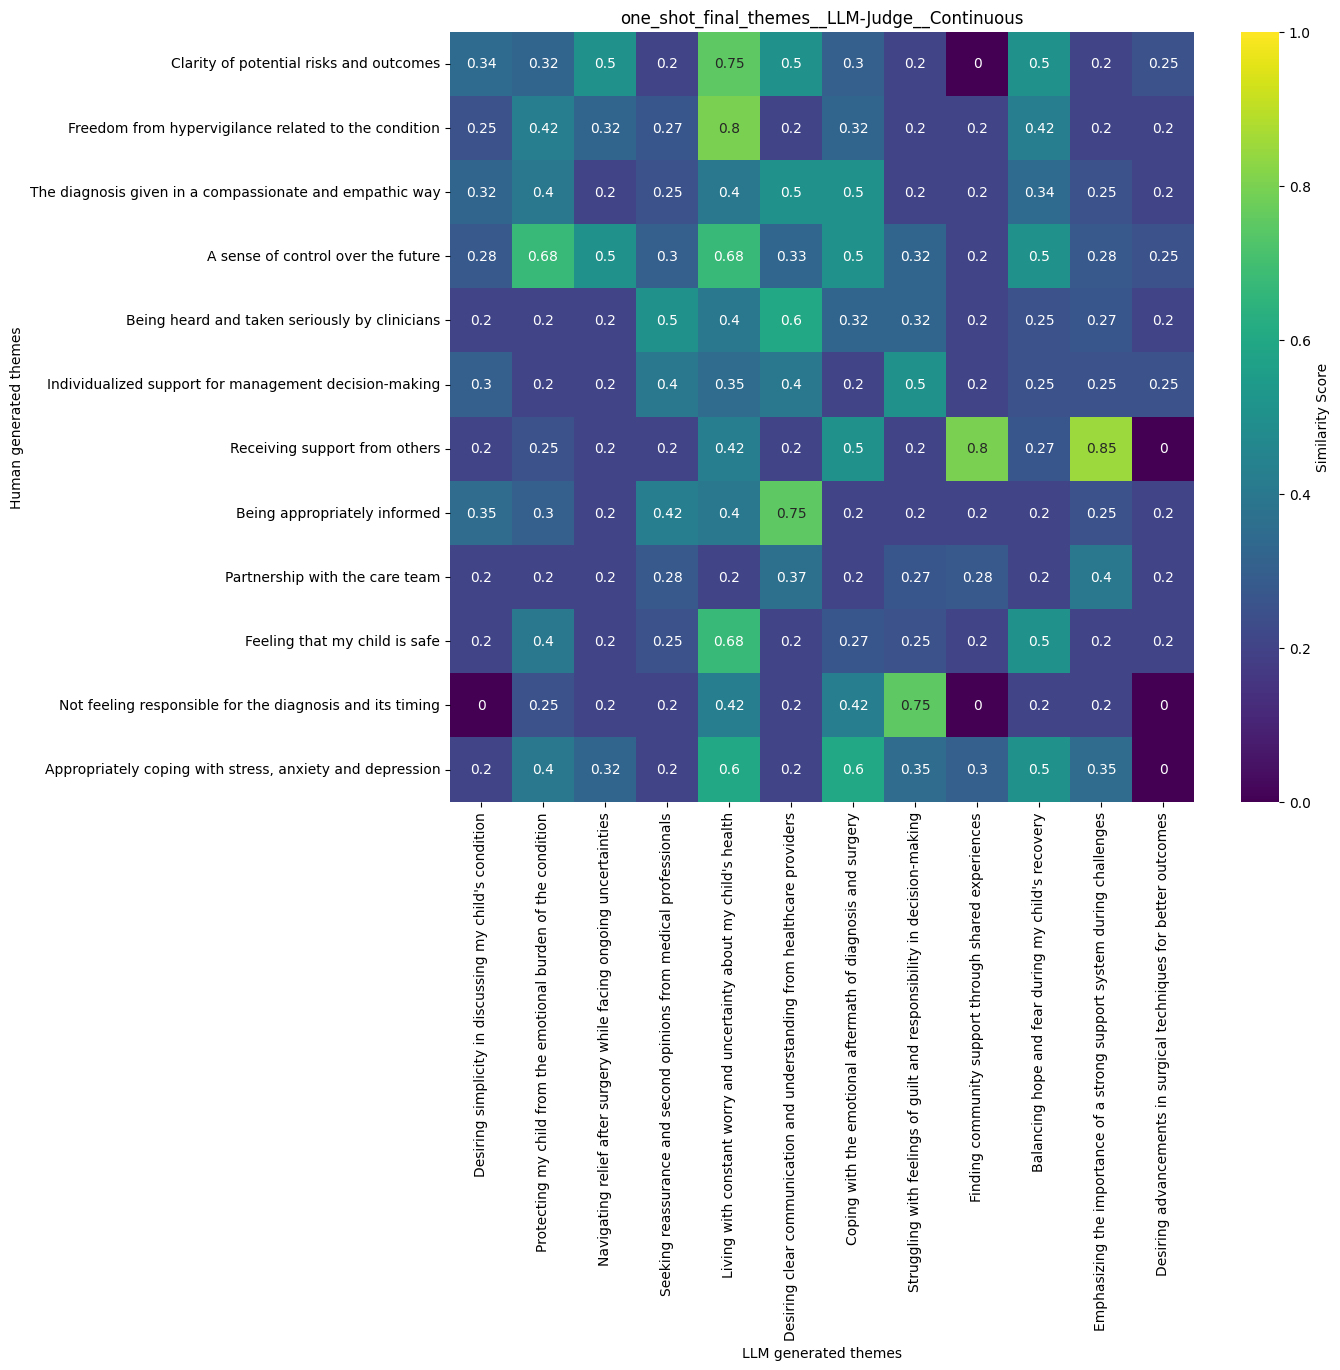

In [360]:
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('one_shot_final_themes__LLM-Judge__Continuous')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

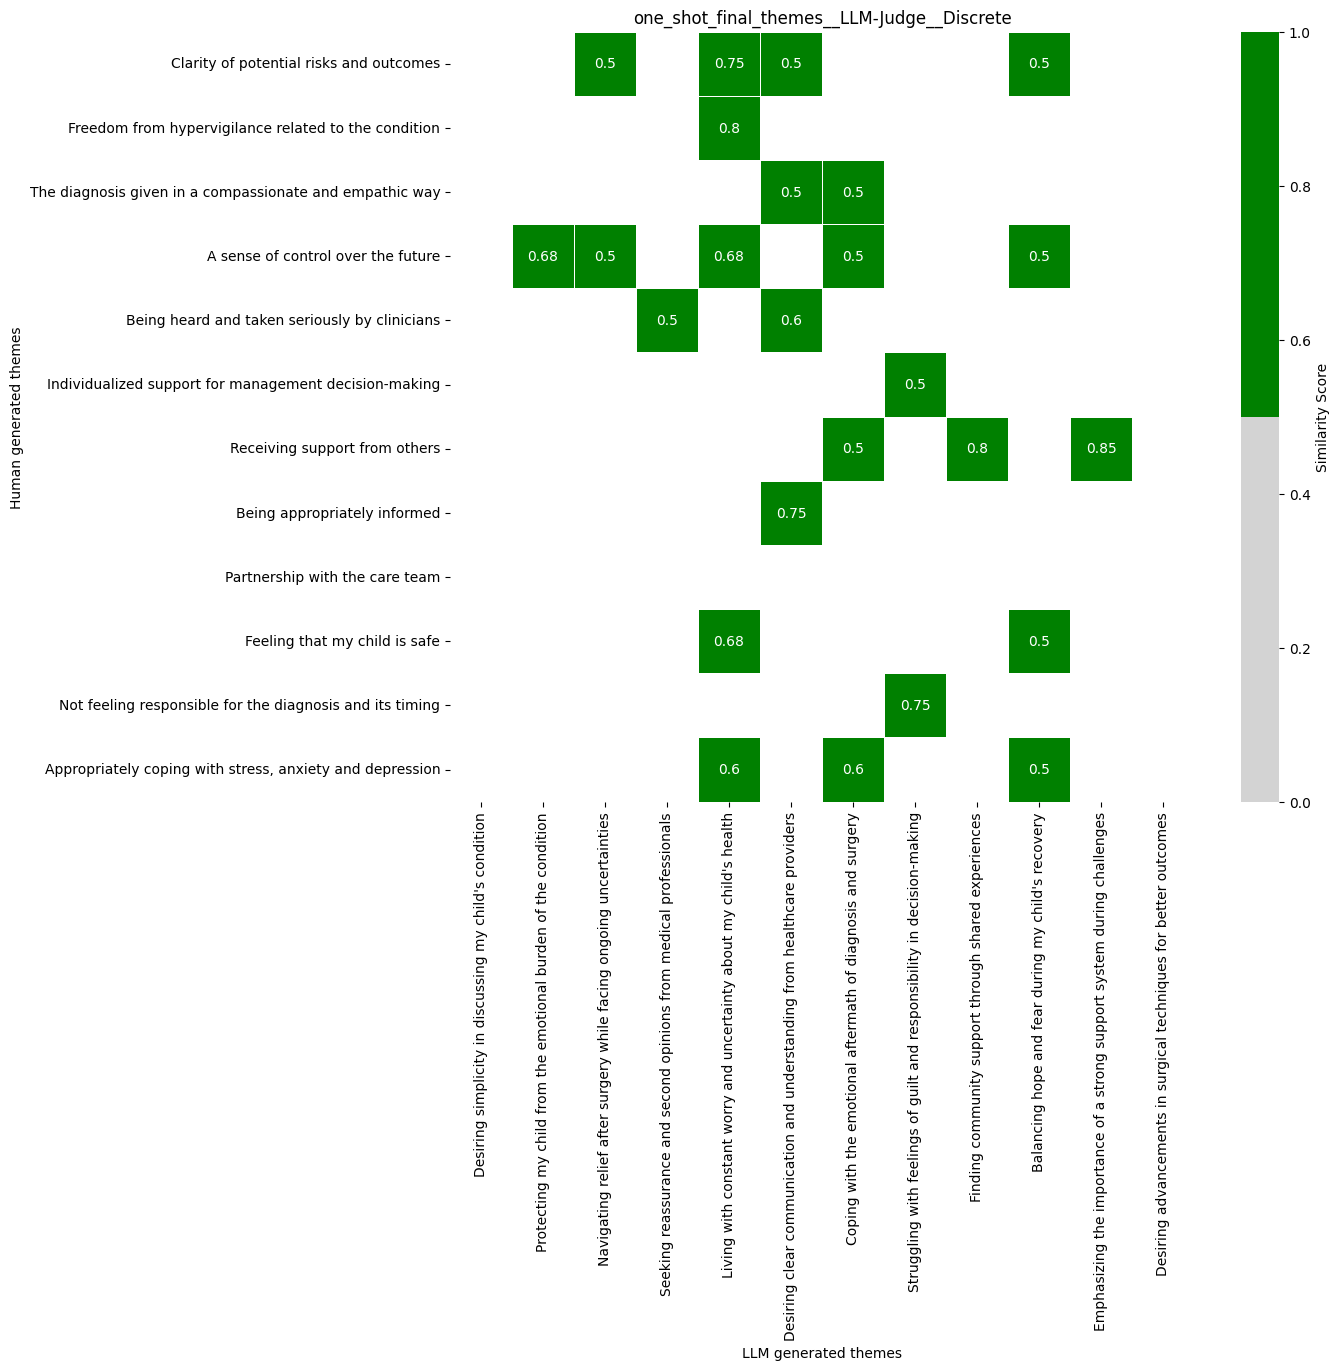

In [361]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_llm_df < 0.5),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('one_shot_final_themes__LLM-Judge__Discrete')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [362]:
similarity_array = similarity_llm_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= 0.5)
percent_high = (high_similarity_count*100/total_cells)
percent_high

17.36111111111111